# Imports and usefull functions

In [1]:
import os, pickle
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
import xgboost as xgb

from src.commons.tools import check_directories, output_path

check_directories()

def plot_roc_curve(model, X, y, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    

    plt.figure(figsize=(8,6))

    for train_idx, test_idx in cv.split(X, y):
        # print(X)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_proba = model.predict_proba(X.iloc[test_idx])[:, 1]

        fpr, tpr, _ = metrics.roc_curve(y.iloc[test_idx], y_proba)
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate tpr for a mean curve
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        plt.plot(fpr, tpr, alpha=0.3, label=f"ROC fold (AUC = {roc_auc:.2f})")

    # Mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)

    # Chance line
    plt.plot([0,1], [0,1], linestyle="--", color="gray")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve with Cross-Validation")
    plt.legend(loc="lower right")
    plt.show()

def apply_cross_validation(model, X,  Y):
    scoring = ('f1', 'accuracy', 'precision', 'recall')
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    smote = SMOTE(random_state=42)
    X, Y = smote.fit_resample(X, Y)
    plot_roc_curve(model, X, Y, cv)
    scores = cross_validate(
        model,
        X, Y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        groups=[f'group_{i+1}' for i in range(len(Y))],
        return_estimator=True,
    )
    stimators = scores['estimator']
    scores.pop('estimator')
    scores = pd.DataFrame(scores)
    return scores, stimators

prediction_dataset = pd.read_csv(os.path.join('..', 'output', 'predictive_mining', 'train_set', 'final_non_correlated_dataset_train.csv'))
categorical_dataset = pd.read_csv(os.path.join('..', 'output', 'descriptive_mining', 'final_description_categorical.csv'))
numerical_dataset = pd.read_csv(os.path.join('..', 'output', 'descriptive_mining', 'final_description_numeric.csv'))

threshold = 0.05
aux = prediction_dataset.corr().loc['retiro']
cols = aux[~aux.isna()&(aux.abs()>threshold)].index
prediction_dataset = prediction_dataset[cols]
X = prediction_dataset.drop('retiro', axis=1)
Y = prediction_dataset['retiro'].astype('category')
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Desc_Cargo_AUXILIAR AMBIENTAL               252 non-null    float64
 1   Desc_Cargo_AUXILIAR DE SERVICIOS GENERALES  252 non-null    float64
 2   Desc_Cargo_CADENERO I                       252 non-null    float64
 3   Desc_Cargo_CONTROLADOR VIAL                 252 non-null    float64
 4   Desc_Cargo_INSPECTOR SST I                  252 non-null    float64
 5   Desc_Cargo_OFICIAL I                        252 non-null    float64
 6   Desc_Cargo_OFICIAL II                       252 non-null    float64
 7   Desc_Cargo_OPERADOR DE RETROEXCAVADORA      252 non-null    float64
 8   Desc_Cargo_OPERADOR GRUA TELESCOPICA        252 non-null    float64
 9   Desc_Cargo_PERFORISTA -LANZADOR             252 non-null    float64
 10  Desc_Cargo_SOL

# Statistical Description

In [2]:
profile_data = ProfileReport(prediction_dataset, minimal=True) # minimal=False
#Guardamos en html el perfilado de datos
profile_data.to_file(output_file=os.path.join('data_profiling', 'prediction_profiling.html'))
profile_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:00<00:00, 12911.66it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# PCA

In [2]:
# 2. Apply PCA
n = 26
pca = PCA(n_components=n)  # reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)
# 3. Results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())
# 4. Put into a DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n)])
df_pca.head()

Explained variance ratio: [0.08767465 0.07265879 0.05788996 0.05580015 0.04620928 0.04014821
 0.03770943 0.03762796 0.03193847 0.03054725 0.03003276 0.02907615
 0.02841278 0.02813742 0.0277067  0.02665006 0.02645712 0.02593159
 0.02570907 0.02449929 0.02393982 0.02268268 0.02154369 0.02022685
 0.01890727 0.01664273]
Cumulative explained variance: [0.08767465 0.16033344 0.2182234  0.27402355 0.32023283 0.36038104
 0.39809047 0.43571843 0.4676569  0.49820415 0.52823691 0.55731306
 0.58572584 0.61386325 0.64156995 0.66822002 0.69467714 0.72060873
 0.74631779 0.77081708 0.7947569  0.81743959 0.83898328 0.85921013
 0.8781174  0.89476013]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,-0.825111,-1.180523,0.772975,1.583642,-0.787346,0.441904,0.273977,-0.562397,1.117730,3.126631,...,-0.099954,0.488647,0.753701,0.632804,-0.988289,0.566867,-0.366742,0.235582,1.296612,0.280123
1,0.523201,1.632751,0.092594,-1.856734,0.952676,-0.070515,0.522796,0.014261,0.070065,-0.033834,...,0.025144,-0.347174,-0.236272,0.043254,-0.398902,0.416181,-0.362609,0.186723,0.175540,-0.170081
2,-1.853813,-1.260078,-0.781603,2.306453,2.132574,-1.489403,-0.761059,-0.485137,-0.896814,0.032972,...,-0.078958,0.246535,0.023314,0.486877,-0.720556,-1.357990,-0.056464,0.855049,0.791573,-0.295115
3,-1.853813,-1.260078,-0.781603,2.306453,2.132574,-1.489403,-0.761059,-0.485137,-0.896814,0.032972,...,-0.078958,0.246535,0.023314,0.486877,-0.720556,-1.357990,-0.056464,0.855049,0.791573,-0.295115
4,-0.779207,-0.541307,0.562975,-1.928345,-0.008676,0.660052,0.206481,-0.370653,0.330563,0.134483,...,-0.018707,-0.163254,0.067877,0.004755,-0.196718,0.146162,0.038608,0.341440,-0.948331,-0.110785


<!-- # XGBoost -->

# XGBoost Classifier

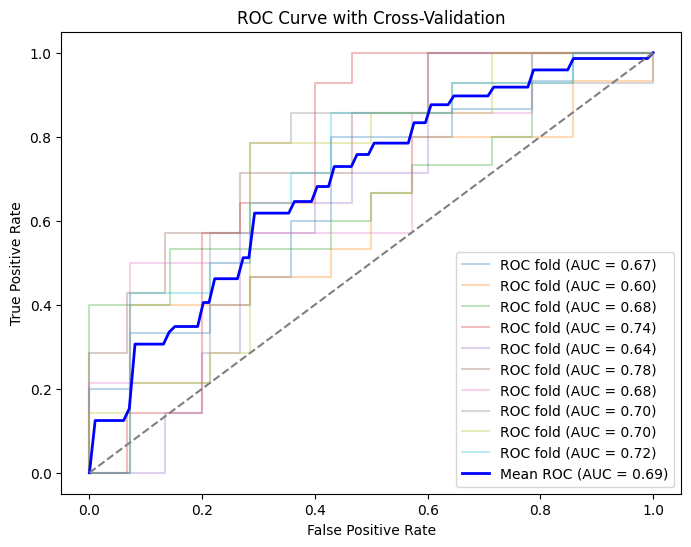

c:\Users\User\miniconda3\envs\data-mining\Lib\site-packages\sklearn\model_selection\_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


fit_time           0.053825
score_time         0.014783
test_f1            0.627193
train_f1           0.961964
test_accuracy      0.636453
train_accuracy     0.961927
test_precision     0.646702
train_precision    0.960643
test_recall        0.630476
train_recall       0.963493
dtype: float64


,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.074231,0.017188,0.705882,0.957198,0.655172,0.957198,0.631579,0.953488,0.800000,0.960938
1,0.061145,0.014714,0.480000,0.961538,0.551724,0.961089,0.600000,0.946970,0.400000,0.976562
2,0.056251,0.014939,0.615385,0.968750,0.655172,0.968872,0.727273,0.968750,0.533333,0.968750
3,0.051850,0.016834,0.620690,0.956522,0.620690,0.957198,0.600000,0.975806,0.642857,0.937984
4,0.047594,0.014613,0.615385,0.972973,0.655172,0.972763,0.666667,0.969231,0.571429,0.976744
5,0.044726,0.014577,0.545455,0.953846,0.655172,0.953307,0.750000,0.946565,0.428571,0.961240
6,0.049932,0.013513,0.533333,0.961240,0.500000,0.961240,0.500000,0.961240,0.571429,0.961240
7,0.049551,0.012598,0.758621,0.961240,0.750000,0.961240,0.733333,0.961240,0.785714,0.961240
8,0.054512,0.014472,0.687500,0.969466,0.642857,0.968992,0.611111,0.954887,0.785714,0.984496
9,0.048457,0.014386,0.709677,0.956863,0.678571,0.957364,0.647059,0.968254,0.785714,0.945736


In [3]:
model_xgb = xgb.XGBClassifier(
    max_depth=13,
    learning_rate=0.5,
    n_estimators=89,
    subsample=0.8,  #enable_categorical=True,
)
scores, xg_stimators = apply_cross_validation(model_xgb, X, Y)
print(scores.mean())
scores

# Perceptron Classifier

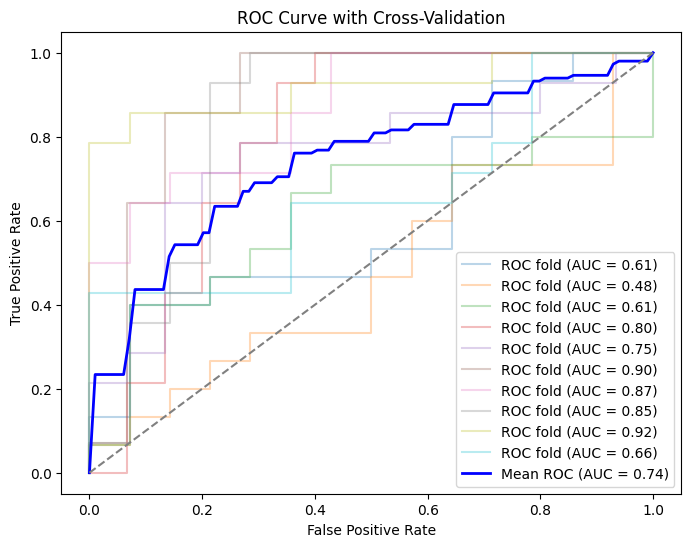

c:\Users\User\miniconda3\envs\data-mining\Lib\site-packages\sklearn\model_selection\_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


fit_time           0.232614
score_time         0.009800
test_f1            0.689625
train_f1           0.934285
test_accuracy      0.679187
train_accuracy     0.933952
test_precision     0.665413
train_precision    0.929543
test_recall        0.724286
train_recall       0.939383
dtype: float64


,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.275757,0.006145,0.588235,0.926641,0.517241,0.926070,0.526316,0.916031,0.666667,0.937500
1,0.282228,0.008527,0.428571,0.941176,0.448276,0.941634,0.461538,0.944882,0.400000,0.937500
2,0.171962,0.010222,0.592593,0.929688,0.620690,0.929961,0.666667,0.929688,0.533333,0.929688
3,0.257777,0.008531,0.666667,0.929688,0.689655,0.929961,0.692308,0.937008,0.642857,0.922481
4,0.252081,0.014146,0.709677,0.943396,0.689655,0.941634,0.647059,0.919118,0.785714,0.968992
5,0.176677,0.009708,0.857143,0.927203,0.862069,0.926070,0.857143,0.916667,0.857143,0.937984
6,0.253400,0.011325,0.774194,0.935361,0.750000,0.934109,0.705882,0.917910,0.857143,0.953488
7,0.241486,0.008181,0.866667,0.938931,0.857143,0.937984,0.812500,0.924812,0.928571,0.953488
8,0.239765,0.010774,0.812500,0.941634,0.785714,0.941860,0.722222,0.945312,0.928571,0.937984
9,0.175011,0.010437,0.600000,0.929134,0.571429,0.930233,0.562500,0.944000,0.642857,0.914729


In [ ]:
modelNN = MLPClassifier(activation='tanh', hidden_layer_sizes=(11, 5), learning_rate='constant',
                        learning_rate_init=0.0062, momentum= 0.3, max_iter=4000, batch_size=100, random_state=3, solver='adam')
scores, nn_stimators = apply_cross_validation(modelNN, X_scaled, Y)
print(scores.mean())
scores

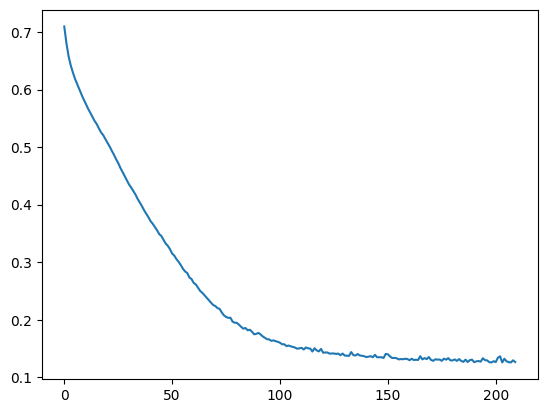

In [5]:
loss_values = modelNN.loss_curve_
plt.plot(loss_values)

# Random Forest Classifier

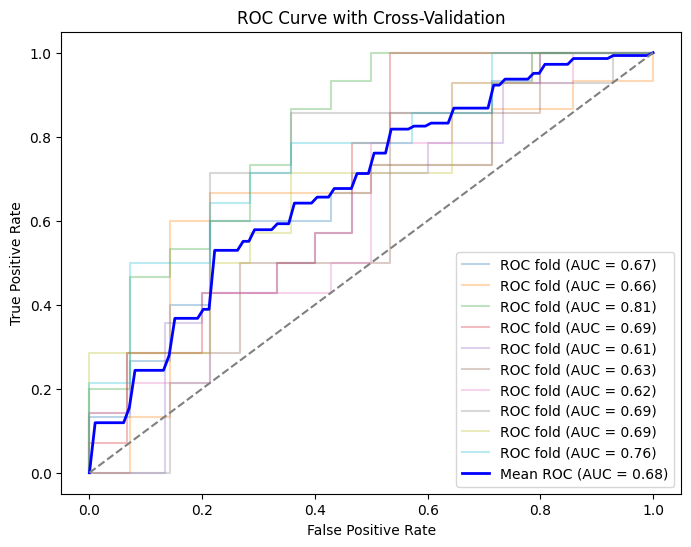

c:\Users\User\miniconda3\envs\data-mining\Lib\site-packages\sklearn\model_selection\_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


fit_time           0.121040
score_time         0.014098
test_f1            0.602475
train_f1           0.880737
test_accuracy      0.622660
train_accuracy     0.883062
test_precision     0.635109
train_precision    0.897745
test_recall        0.587143
train_recall       0.864795
dtype: float64


,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.126400,0.012362,0.625000,0.890625,0.586207,0.891051,0.588235,0.890625,0.666667,0.890625
1,0.132980,0.014814,0.692308,0.896000,0.724138,0.898833,0.818182,0.918033,0.600000,0.875000
2,0.106051,0.017355,0.640000,0.860656,0.689655,0.867704,0.800000,0.905172,0.533333,0.820312
3,0.117998,0.013055,0.551724,0.868526,0.551724,0.871595,0.533333,0.893443,0.571429,0.844961
4,0.119600,0.012964,0.538462,0.883721,0.586207,0.883268,0.583333,0.883721,0.500000,0.883721
5,0.120396,0.011724,0.363636,0.886275,0.517241,0.887160,0.500000,0.896825,0.285714,0.875969
6,0.127544,0.013886,0.500000,0.868526,0.500000,0.872093,0.500000,0.893443,0.500000,0.844961
7,0.112007,0.018365,0.714286,0.880000,0.714286,0.883721,0.714286,0.909091,0.714286,0.852713
8,0.123426,0.010878,0.689655,0.869565,0.678571,0.872093,0.666667,0.887097,0.714286,0.852713
9,0.123996,0.015574,0.709677,0.903475,0.678571,0.903101,0.647059,0.900000,0.785714,0.906977


In [6]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(n_estimators=95,  max_samples=0.65, criterion='gini',
                                 max_depth=None, min_samples_leaf=3, random_state=26)
scores, nn_stimators = apply_cross_validation(model_rf, X, Y)
print(scores.mean())
scores

# Building final model

The best model is Perceptron with 0.74 ROC and F1 0.69. Lets build a pipeline to use it in the future.

In [7]:
perceptron_pipeline = Pipeline([
    ("scaler", StandardScaler()),          # normalize features
    ("clf", MLPClassifier(activation="tanh", hidden_layer_sizes=(11, 5), learning_rate='constant',
                        learning_rate_init=0.0062, momentum= 0.3, max_iter=4000, batch_size=100, random_state=3, solver='adam'))
])
perceptron_pipeline.fit(X, Y)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(11, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.0001


### Saving selected model

In [8]:
model_path = os.path.join('models', 'perceptron_model.pkl')
variables = X.columns._values
with open(model_path, 'wb') as f:
    pickle.dump([perceptron_pipeline, variables], f)